# Stroke Prediction Project

### Context
According to the World Health Organization (WHO) stroke is the 2nd leading cause of death globally, responsible for approximately 11% of total deaths. This dataset is used to predict whether a patient is likely to get stroke based on the input parameters like gender, age, various diseases, and smoking status. Each row in the data provides relavant information about the patient.

### Attribute Information
1) id: unique identifier
2) gender: "Male", "Female" or "Other"
3) age: age of the patient
4) hypertension: 0 if the patient doesn't have hypertension, 1 if the patient has hypertension
5) heart_disease: 0 if the patient doesn't have any heart diseases, 1 if the patient has a heart disease
6) ever_married: "No" or "Yes"
7) work_type: "children", "Govt_jov", "Never_worked", "Private" or "Self-employed"
8) Residence_type: "Rural" or "Urban"
9) avg_glucose_level: average glucose level in blood
10) bmi: body mass index
11) smoking_status: "formerly smoked", "never smoked", "smokes" or "Unknown"*
12) stroke: 1 if the patient had a stroke or 0 if not

*Note: "Unknown" in smoking_status means that the information is unavailable for this patient

# Goal

The goal is to create a model that performs well at predicting whether a person is likely to have a stroke or not based on the information of the other columns. The model will then be serialized and deployed.

# Project Outline

1. **Data Pre-processing**
2. **EDA**
3. **Feature Selection & Engineering**
4. **Model Selection & Training**
5. **Model Interpretation & Serializing**

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
import scipy.stats as stats
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from autofeat import AutoFeatClassifier, FeatureSelector
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.impute import KNNImputer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
import optuna
from sklearn.model_selection import cross_validate
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
    roc_auc_score,
    f1_score,
    precision_score,
    recall_score,
    classification_report,
    make_scorer,
    fbeta_score,
)

f_beta = make_scorer(fbeta_score, beta=2)

import functions
import shap

from sklearn import set_config
from sklearn.exceptions import ConvergenceWarning
import warnings
import sys, os

warnings.filterwarnings("ignore")

if not sys.warnoptions:
    warnings.simplefilter("ignore")
    os.environ["PYTHONWARNINGS"] = "ignore"

set_config(transform_output="pandas")
sns.set_theme(style="ticks")

/Users/gerigjylbegu/Documents/Turing/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
stroke = pd.read_csv("healthcare-dataset-stroke-data.csv", index_col=0)

# Data pre-processing

In this section I will check for general information about the data.

Starting with taking a look at the data:

In [3]:
stroke

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
id,,,,,,,,,,,
9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1
...,...,...,...,...,...,...,...,...,...,...,...
18234,Female,80.0,1,0,Yes,Private,Urban,83.75,NaN,never smoked,0
44873,Female,81.0,0,0,Yes,Self-employed,Urban,125.20,40.0,never smoked,0
19723,Female,35.0,0,0,Yes,Self-employed,Rural,82.99,30.6,never smoked,0


Data types:

In [4]:
stroke.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5110 entries, 9046 to 44679
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             5110 non-null   object 
 1   age                5110 non-null   float64
 2   hypertension       5110 non-null   int64  
 3   heart_disease      5110 non-null   int64  
 4   ever_married       5110 non-null   object 
 5   work_type          5110 non-null   object 
 6   Residence_type     5110 non-null   object 
 7   avg_glucose_level  5110 non-null   float64
 8   bmi                4909 non-null   float64
 9   smoking_status     5110 non-null   object 
 10  stroke             5110 non-null   int64  
dtypes: float64(3), int64(3), object(5)
memory usage: 479.1+ KB


Observations:

- The id column does not provide any valuable information for determining the possibility of having a stroke, hence it is used as an index column.
- Categorical information columns: `gender`, `hypertension`, `heart_disease`, `ever_married`, `work_type`, `Residence_type`, `smoking_status`.
- Numerical (continuous) information column: `gender`, `age`, `avg_glucose_level`, `bmi`
- The `bmi` and `smoking_status` columns contain null values, which are respectively marked as NaN or 'Unknown'.

In [5]:
for_binary_encoding = ["gender", "ever_married", "Residence_type"]
for_onehot_encoding = ["work_type", "smoking_status"]

Let's check what percentage of the two columns are null values:

In [6]:
null_stroke = stroke.copy()

null_stroke.smoking_status.replace("Unknown", np.nan, inplace=True)

nulls = null_stroke.isna().sum()

nulls[nulls != 0]

bmi                201
smoking_status    1544
dtype: int64

In [7]:
print(
    f"There are {null_stroke.isna().any(axis=1).sum()} instances with missing data which makes "
)

There are 1684 instances with missing data which makes 


Observations:

- There are 201 missing values in the bmi column and 1554 in the smoking_status one.
- Some of the data instances miss both at the same time, thus there are 1684 instances (rows) with missing data in either column.
- The 1554 instances of the smoking_status column can be considered as a separate category.
- If, I use a model tree-based model, which can deal with missing data then I do not need to remove the 201 instances from bmi. Otherwize, I have to drop them. But compared to the size of the dataset, it is not a huge loss if I remove them.

Let's check for duplicates:

In [8]:
dups = stroke.duplicated().sum()
print(
    "There are no duplicates."
    if dups == 0
    else f"There are {dups} duplicates which make {dups/len(stroke) * 100:.2f}% of the dataset."
)

There are no duplicates.


In [9]:
outlier_df = functions.find_outliers_iqr(stroke).drop(
    columns=["hypertension", "heart_disease", "stroke"]
)
outlier_num = outlier_df.sum().sum()

print(
    "There are no outliers."
    if outlier_num == 0
    else f"There are {outlier_num} outliers which make {outlier_num / len(stroke) * 100:.2f}% of the dataset."
)

There are 737 outliers which make 14.42% of the dataset.


In [10]:
outlier_df.sum()[outlier_df.sum() != 0]

avg_glucose_level    627
bmi                  110
dtype: int64

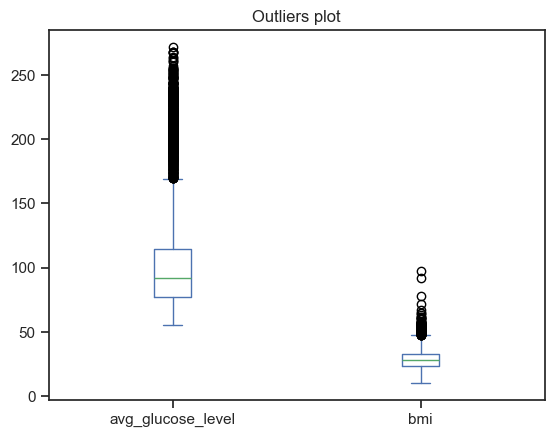

In [11]:
_ = stroke[outlier_df.sum()[outlier_df.sum() != 0].index].plot(
    kind="box", title="Outliers plot"
)

Observations:

- There are not many outliers on this dataset, and they are found on the avg_glucose_level and bmi columns. 
- From the boxplot of the outliers, I can see that the outliers represent the people that have values of glucose levels and bmi above the norm. These data recordings are not uncommon and therefore not due to mistake, so the outliers represent genuine data.

Descriptive statistics:

In [12]:
stroke.describe(include="all").T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
gender,5110,3,Female,2994,NaN,NaN,NaN,NaN,NaN,NaN,NaN
age,5110.0,NaN,NaN,NaN,43.226614,22.612647,0.08,25.0,45.0,61.0,82.0
hypertension,5110.0,NaN,NaN,NaN,0.097456,0.296607,0.0,0.0,0.0,0.0,1.0
heart_disease,5110.0,NaN,NaN,NaN,0.054012,0.226063,0.0,0.0,0.0,0.0,1.0
ever_married,5110,2,Yes,3353,NaN,NaN,NaN,NaN,NaN,NaN,NaN
work_type,5110,5,Private,2925,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Residence_type,5110,2,Urban,2596,NaN,NaN,NaN,NaN,NaN,NaN,NaN
avg_glucose_level,5110.0,NaN,NaN,NaN,106.147677,45.28356,55.12,77.245,91.885,114.09,271.74
bmi,4909.0,NaN,NaN,NaN,28.893237,7.854067,10.3,23.5,28.1,33.1,97.6
smoking_status,5110,4,never smoked,1892,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Observation:

- Most of the findings so far check out, but some columns require further investigation, such as:
    - The age column presents a min value of 0.08. Does that represent an infant 29 days old or is it a wrong value?
    - The min bmi value is 10.3. Does that represent the bmi of an infant or is that an erroneus value?
    - The min avg_glucose_level value is 55, which while possible is quite low. Does that represent the glucose levels of an infant or a sick adult, or is that an erroneus value?

- The gender column needs to be explored because there is a third category.
    
Unfortunately, I do not have any information on how the data was collected, nor about the units of the columns. However, these questions and columns need to be further investigated.

In [13]:
stroke.gender.value_counts()

gender
Female    2994
Male      2115
Other        1
Name: count, dtype: int64

In [14]:
stroke[stroke.gender == "Other"]

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
id,,,,,,,,,,,
56156,Other,26.0,0,0,No,Private,Rural,143.33,22.4,formerly smoked,0


Observation:

- The "Other" category only has one instance therefore I will group it with the minority category in this case, the "Male" one.

In [15]:
stroke.gender.replace({"Other": "Male"}, inplace=True)

# EDA

In this section I will explore the data through plots and graphs, starting with the numerical columns and then the categorical ones. I will also check for any correlation between the numerical columns.

First, in order to ensure consistency of our findings, let's do a train-test split on the data:

In [16]:
eda = stroke.copy()
for i in ["hypertension", "heart_disease", "stroke"]:
    eda[i].replace({1: "Yes", 0: "No"}, inplace=True)

X = eda.drop(columns=["stroke"])
y = eda.stroke

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y,
)

Let's check the age distribution:

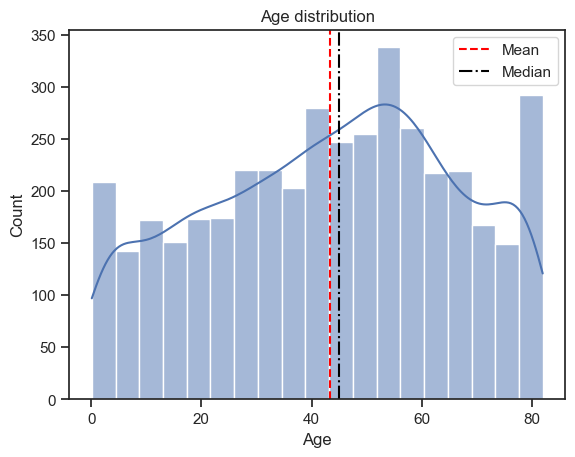

In [17]:
_ = sns.histplot(x=X_train.age, kde=True)
plt.title("Age distribution")
plt.xlabel("Age")

plt.axvline(X_train.age.mean(), color="red", ls="--", label="Mean")
plt.axvline(X_train.age.median(), color="black", ls="-.", label="Median")
_ = plt.legend()

Observations:

- The age distribution is not normal, however, so far all the age groups seem to be well represented.
- The age range however needs a bit more investigation.

Let's check the instances with floating point values for age in the dataframe:

In [18]:
eda.sort_values(by="age").head(10)

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
id,,,,,,,,,,,
29955,Male,0.08,No,No,No,children,Rural,70.33,16.9,Unknown,No
47350,Female,0.08,No,No,No,children,Urban,139.67,14.1,Unknown,No
22877,Male,0.16,No,No,No,children,Urban,114.71,17.4,Unknown,No
8247,Male,0.16,No,No,No,children,Urban,109.52,13.9,Unknown,No
41500,Male,0.16,No,No,No,children,Rural,69.79,13.0,Unknown,No
11371,Male,0.24,No,No,No,children,Urban,89.28,14.2,Unknown,No
53279,Male,0.24,No,No,No,children,Rural,118.87,16.3,Unknown,No
64974,Male,0.24,No,No,No,children,Urban,58.35,18.6,Unknown,No
69222,Male,0.24,No,No,No,children,Urban,57.09,19.4,Unknown,No


As previously suspected the floating point ages coincide with newborns, therefore these datapoints are valid.

Let's check the BMI distribution:

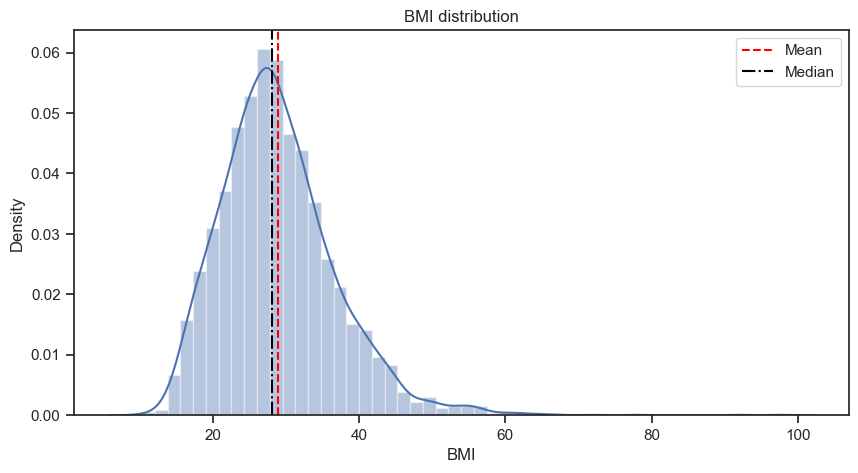

In [19]:
plt.figure(figsize=(10, 5))
_ = sns.distplot(x=X_train.bmi)
plt.title("BMI distribution")
plt.xlabel("BMI")

plt.axvline(X_train.bmi.mean(), color="red", ls="--", label="Mean")
plt.axvline(X_train.bmi.median(), color="black", ls="-.", label="Median")
_ = plt.legend()

Observations:

- The distribution seems a bit skewed to the right due to the large outlier values, but otherwize it is normal.
- This column could perhaps benefit from logarithmic transformation in order to reduce the skew.

To confirm the normailty of the distribution, let's check the Shapiro-Wilk test:

In [20]:
print(
    "The distribution is not normal."
    if stats.shapiro(eda.bmi.ffill()).pvalue < 0.05
    else "The distribution is normal."
)

The distribution is not normal.


Let's check the extreme values on both ends:

In [21]:
eda.sort_values(by="bmi").head(10)

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
id,,,,,,,,,,,
38043,Female,1.24,No,No,No,children,Rural,122.04,10.3,Unknown,No
3205,Female,79.00,No,No,Yes,Self-employed,Urban,79.03,11.3,Unknown,No
59993,Male,40.00,No,No,Yes,Private,Rural,60.96,11.5,never smoked,No
20364,Female,4.00,No,No,No,children,Urban,107.25,12.0,Unknown,No
45893,Female,8.00,No,No,No,children,Urban,106.51,12.3,Unknown,No
53924,Female,1.08,No,No,No,children,Urban,159.39,12.8,Unknown,No
41500,Male,0.16,No,No,No,children,Rural,69.79,13.0,Unknown,No
52859,Female,4.00,No,No,No,children,Urban,61.54,13.2,Unknown,No
31113,Female,1.16,No,No,No,children,Urban,86.00,13.3,Unknown,No


In [22]:
eda.sort_values(by="bmi", ascending=False).head(10)

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
id,,,,,,,,,,,
56420,Male,17.0,Yes,No,No,Private,Rural,61.67,97.6,Unknown,No
51856,Male,38.0,Yes,No,Yes,Private,Rural,56.90,92.0,never smoked,No
41097,Female,23.0,Yes,No,No,Private,Urban,70.03,78.0,smokes,No
545,Male,42.0,No,No,Yes,Private,Rural,210.48,71.9,never smoked,No
37759,Female,53.0,No,No,Yes,Private,Rural,72.63,66.8,Unknown,No
66333,Male,52.0,No,No,Yes,Self-employed,Urban,78.40,64.8,never smoked,No
70670,Female,27.0,No,No,Yes,Private,Rural,57.96,64.4,never smoked,No
20292,Female,24.0,No,No,Yes,Private,Urban,85.55,63.3,never smoked,No
72784,Female,52.0,No,No,Yes,Private,Rural,118.46,61.6,smokes,No


The majority of the instances with low BMI coincide with children/newborns. However, there are two adults with low BMI.

After further investigating, here are the categories of BMI based on the ranges:

- Underweight: < 18.5
- Normal weight: 18.5 - 24.9
- Overweight: 25 - 29.9
- Obesity: > 30

By comparing with the data that I have, the two adults will then have to be classified as underweight. The data points in this case are genuine.

On the other hand the datapoints on the higher end seem physiologically hard to attain. A teenager with a BMI of 97 is unlikely. [The highest recorded BMI](https://en.wikipedia.org/wiki/List_of_heaviest_people) in history has been 204, which by comparison puts the outliers of the dataset in the range of possible.

All in all, I will be considering these points as valid readings of BMI.

Let's check the average glucose level distribution:

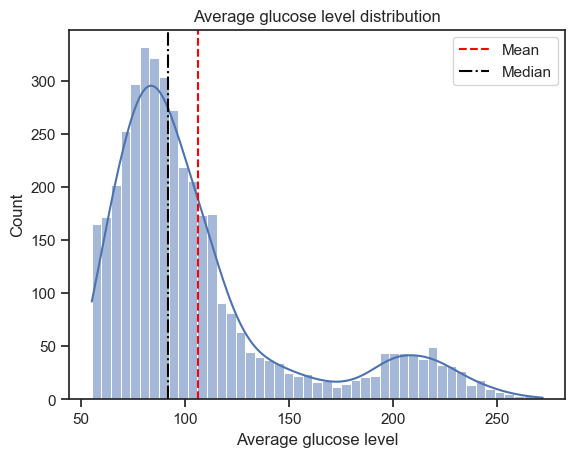

In [23]:
_ = sns.histplot(x=X_train.avg_glucose_level, kde=True)
plt.title("Average glucose level distribution")
plt.xlabel("Average glucose level")

plt.axvline(X_train.avg_glucose_level.mean(), color="red", ls="--", label="Mean")
plt.axvline(X_train.avg_glucose_level.median(), color="black", ls="-.", label="Median")
_ = plt.legend()

Observations:

- The distribution of the average glucose level is not normal. It represents a bimodal shape.
- As verfied before, this is due to the outliers.

Let's have a look at the extreme values:

In [24]:
eda.sort_values(by="avg_glucose_level").head(6)

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
id,,,,,,,,,,,
60562,Female,21.0,No,No,No,Private,Rural,55.12,21.8,never smoked,No
37404,Male,42.0,No,No,Yes,Private,Urban,55.22,27.0,never smoked,No
43028,Male,66.0,No,No,Yes,Self-employed,Rural,55.23,28.9,Unknown,No
61300,Male,20.0,No,No,No,Private,Urban,55.25,20.4,never smoked,No
72547,Male,61.0,No,No,Yes,Private,Rural,55.26,33.2,Unknown,No
41033,Female,31.0,No,No,Yes,Govt_job,Rural,55.27,32.5,formerly smoked,No


In [25]:
eda.sort_values(by="avg_glucose_level", ascending=False).head(6)

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
id,,,,,,,,,,,
69112,Male,68.0,Yes,Yes,Yes,Private,Rural,271.74,31.1,smokes,Yes
22440,Female,49.0,No,No,Yes,Private,Urban,267.76,29.3,formerly smoked,No
26267,Female,76.0,No,No,Yes,Self-employed,Urban,267.61,27.9,smokes,No
10995,Male,76.0,Yes,No,Yes,Private,Rural,267.60,30.5,never smoked,No
27626,Female,60.0,No,No,No,Govt_job,Rural,266.59,25.5,never smoked,No
13155,Female,67.0,Yes,No,Yes,Govt_job,Rural,263.56,26.3,never smoked,No


Again, here I do not have infromation on how the data was measured or collected. Is the column representing fasting or postprandial glucose levels?

The ranges for the fasting glucose levels are:

- Normal: 70 - 100
- Prediabetes: 101 - 125
- Diabetes: > 126

For postprandial:

- Normal: < 140
- Prediabetes: 140 - 199
- Diabetes: > 200

Given these I would have to judge that the recordings are perhaps mixed, as some patients might have been fasting, while others not. So the ranges below 70 are therefore hypoglycemic and those above 200 are severe diabetics. However, this mixture of readings makes it hard for the model and/or whomever investigates the data to distinguish between what is considered normal and what is not.

Let's check the relationship of these 3 numerical columns with the target variable:

<Figure size 2000x1000 with 0 Axes>

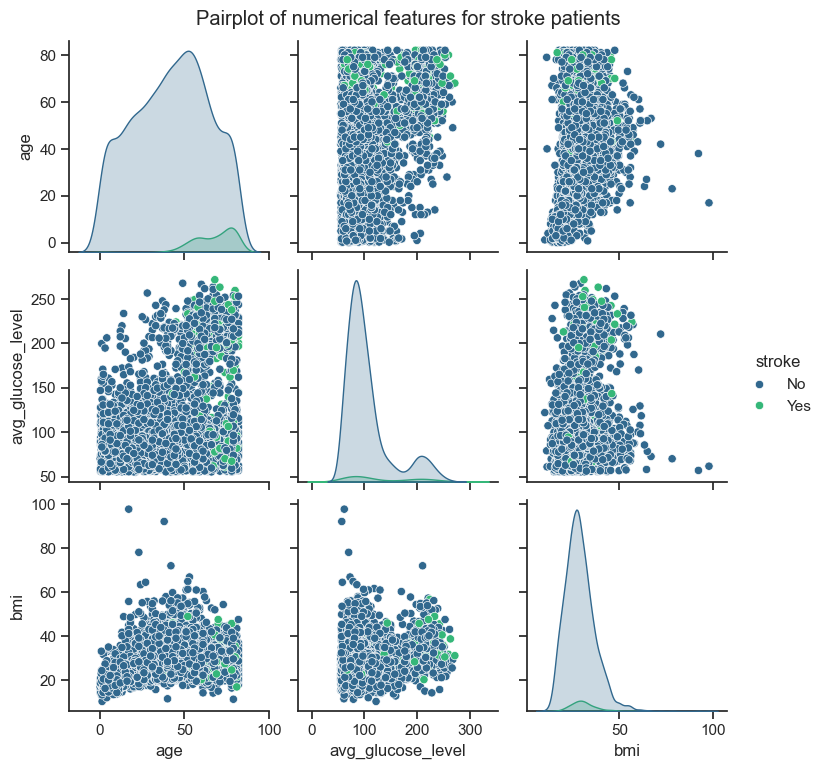

In [26]:
num_feat = ["age", "avg_glucose_level", "bmi"]

plt.figure(figsize=(20, 10))
_ = sns.pairplot(
    pd.concat([X_train, y_train], axis=1),
    vars=num_feat,
    hue="stroke",
    palette="viridis",
)
_ = plt.suptitle("Pairplot of numerical features for stroke patients", y=1.02)

Observations:

- The pairplot does not indicate much of acorrelation between the numerical features themselves. Therefore, I suspect that a linear model would not be helpful in this case, as it cannot capture the relationship between the target and the numerical features.

- The most obvious observation from this pairplot is that the stroke patients are greatly under-represented as compared to the non-stroke patients. 

This imbalance could prove problematic. However, synthetic oversampling techniques might prove to be problematic since they could create data points that are not representative of the real world (like smoking babies for example), while undersampling techniques could lead to information loss.

In such a case I would like to try to train the model without addressing this imbalance and see how it performs.

Let's check for the distribution of the categorical columns:

Text(0.5, 0.98, 'Categorical Features Count Plots')

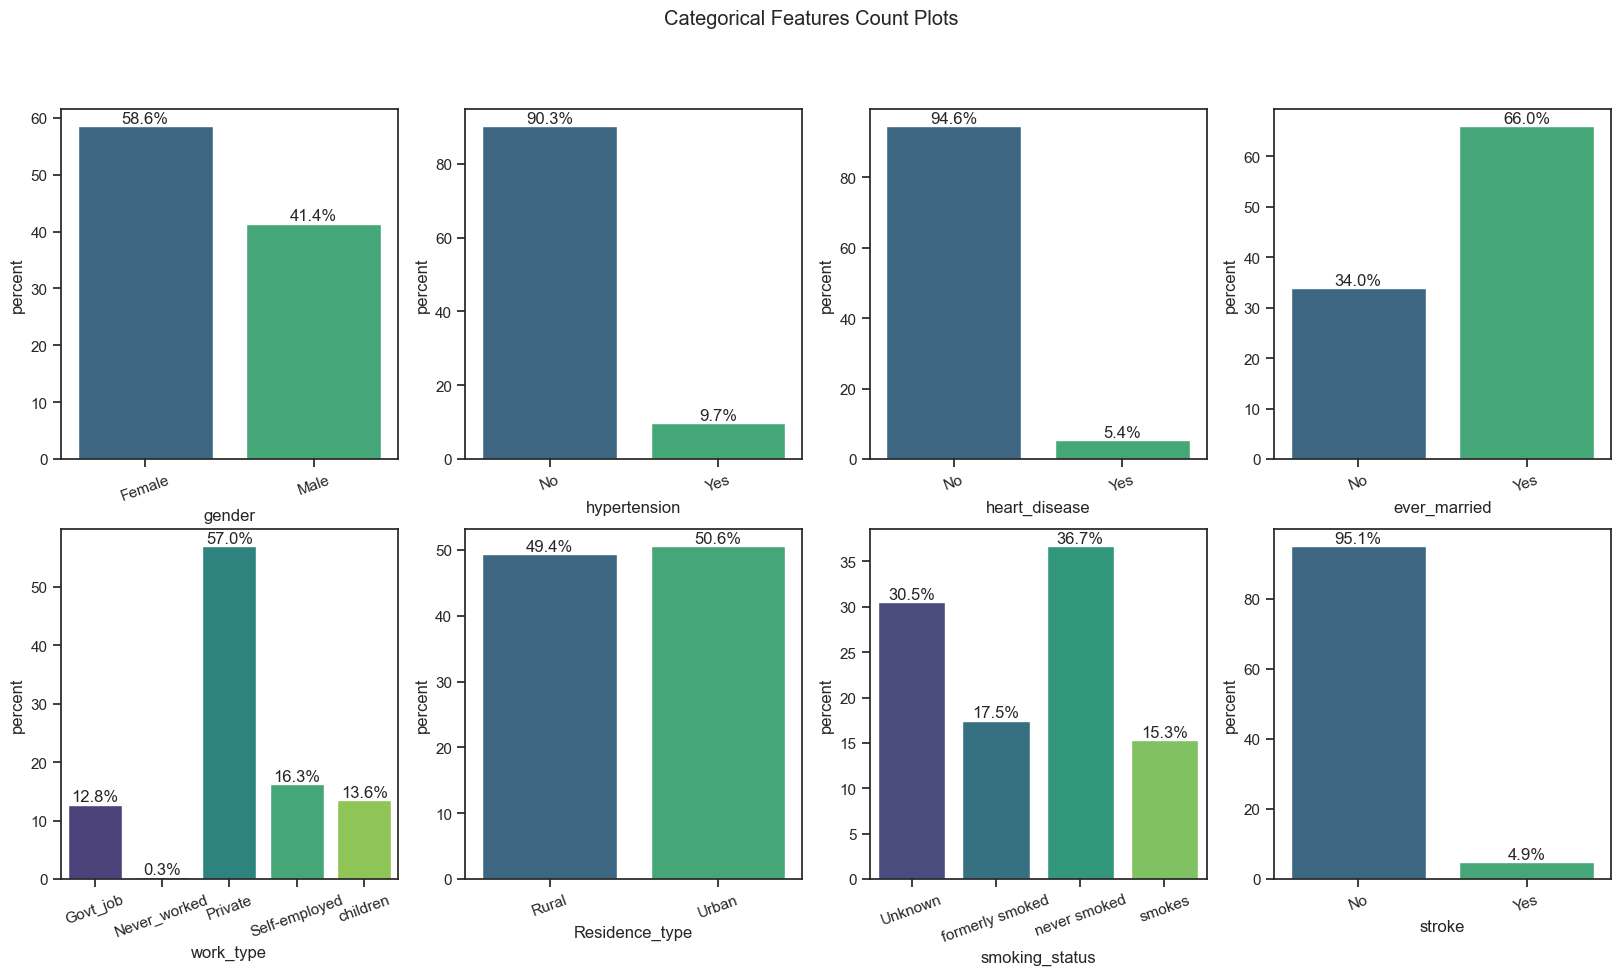

In [27]:
cat_feat = [col for col in X.columns if col not in num_feat]

cat_dist = pd.concat([X_train[cat_feat], y_train], axis=1)

fig, ax = plt.subplots(2, 4, figsize=(20, 10))
for (
    n,
    f,
) in enumerate(cat_dist.columns):
    plt.subplot(2, 4, n + 1)
    fig = sns.countplot(
        data=cat_dist,
        x=f,
        palette="viridis",
        stat="percent",
        order=(cat_dist[f].value_counts().sort_index().index.tolist()),
    )
    plt.xticks(rotation=20)
    functions.annotate_bars(fig)

plt.suptitle("Categorical Features Count Plots")

Observations:

- In general all of the columns are really imbalanced. While this is not necessarily a problem when it comes to the feature columns (depends on the disptribution between the two classes that we are trying to predict), it most definately is for our target column.

- The geographical location (Residence type) seems to be quite balanced in contrast to the other columns.

- Children make up 13.6% of the dataset, however, this in this age group, the possibility of the stroke is only associted with pre-natal health issues and/or genetic disorders and not lifestyle choices. It is therefore reasonable to assume that this group does not teach the model a lot about the target variable. As a result, I will drop this group.

Let's check the categorical features hued by the target variable:

Text(0.5, 0.98, 'Categorical Features Count Plots')

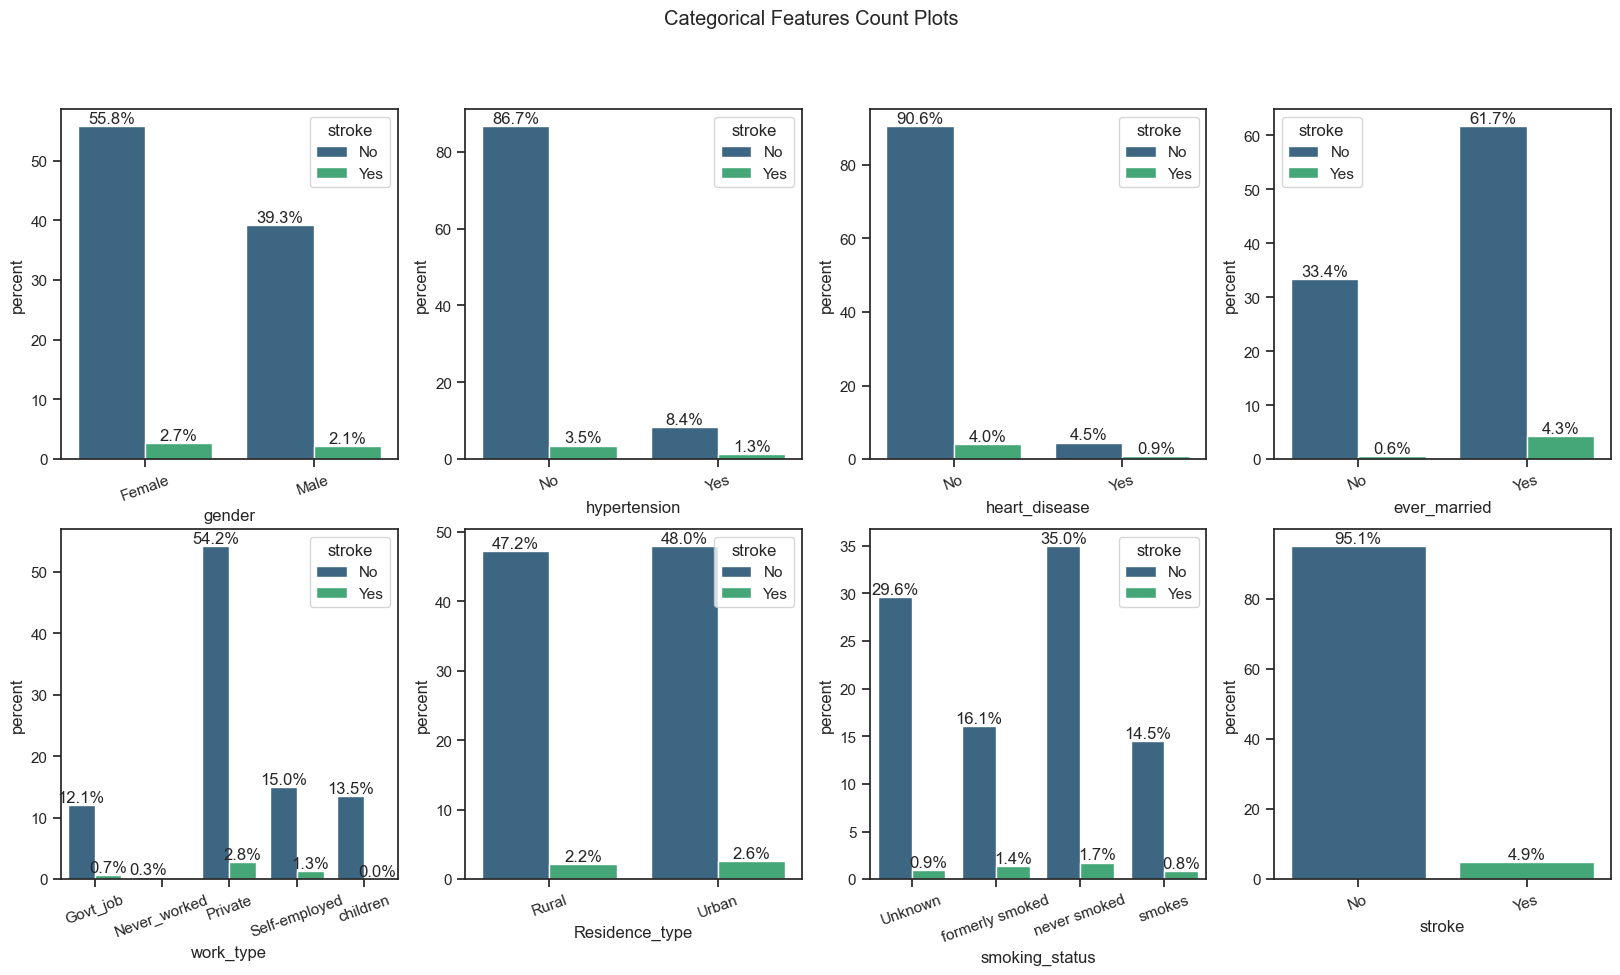

In [28]:
cat_feat = [col for col in X.columns if col not in num_feat]

cat_dist = pd.concat([X_train[cat_feat], y_train], axis=1)

fig, ax = plt.subplots(2, 4, figsize=(20, 10))
for (
    n,
    f,
) in enumerate(cat_dist.columns):
    plt.subplot(2, 4, n + 1)
    fig = sns.countplot(
        data=cat_dist,
        x=f,
        hue="stroke",
        palette="viridis",
        stat="percent",
        order=(cat_dist[f].value_counts().sort_index().index.tolist()),
    )
    plt.xticks(rotation=20)
    functions.annotate_bars(fig)

plt.suptitle("Categorical Features Count Plots")

Observation:

- This confirms the observation from the previous plot.

- Focusing on the children age group, none of them seem to have had a stroke, so I will indeed exclude this group from the model training.

Let's check the correlation between the numerical columns:

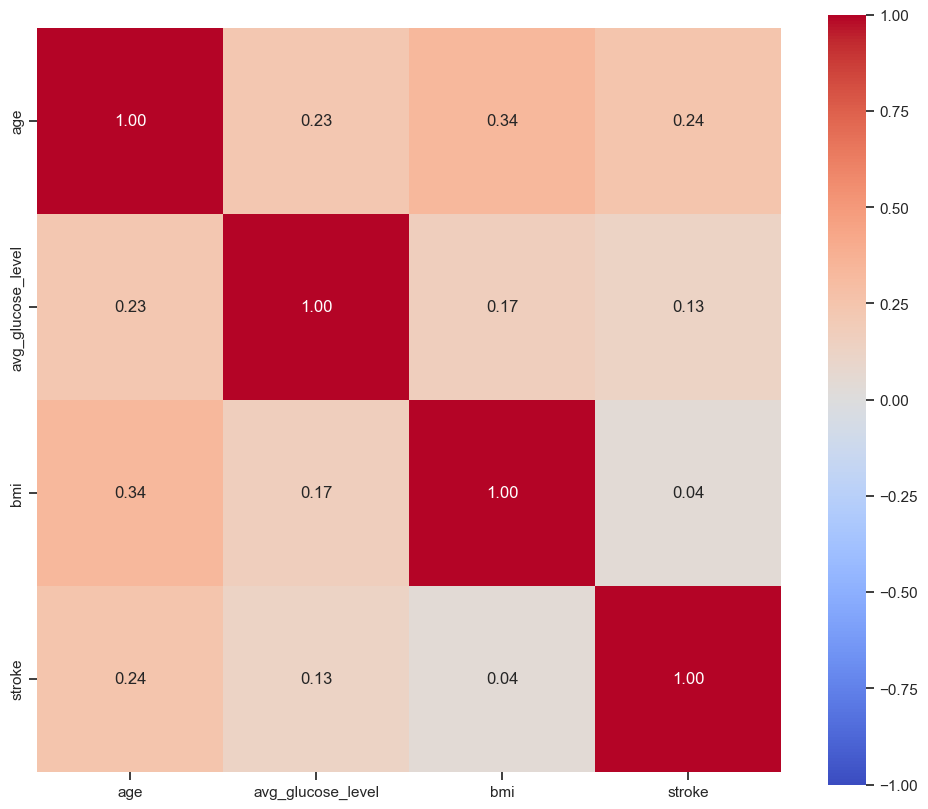

In [29]:
corr_matrix = pd.concat([X_train, y_train.replace({"No": 0, "Yes": 1})], axis=1).corr(
    numeric_only=True
)
plt.figure(figsize=(12, 10))
_ = sns.heatmap(
    corr_matrix,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    square=True,
    vmax=1,
    vmin=-1,
)

In [30]:
pb_corr = X_train[num_feat].corrwith(
    y_train.replace({"No": 0, "Yes": 1}), method=stats.pointbiserialr
)
pb_corr.index = ["corr", "p-value"]

pb_corr

,age,avg_glucose_level,bmi
corr,2.434040e-01,1.253284e-01,0.043810
p-value,3.314088e-56,8.805547e-16,0.006094


Observation:

- There is very little evidence of multicolinearity. 
- The point biserial correlation seems low at first glance, but the p-values are all below 0.05 which indicates that the numerical features are all statistically associated with the target variable.
- I suspect then that a linear model would not perform well at all in this case. I will be therefore using an SVM classifier, and a few tree based models to see which one performs the best


### Hypothesis testing

Now I will check the relationship of the categorical columns with the target variable using the chi2 test.

- H_O: The feature is not statistically associated with the target. The columns are independent.
- H_A: The feature is statistically associated with the target. The columns are dependent.

In [31]:
from sklearn.preprocessing import LabelBinarizer

h_testing = stroke.copy()
lb = LabelBinarizer()

for col in for_binary_encoding:
    h_testing[col] = lb.fit_transform(h_testing[col])

h_testing = pd.get_dummies(
    h_testing,
    columns=for_onehot_encoding,
)
cat_feat_2 = h_testing.drop(columns=num_feat).columns.to_list()
functions.chi2_test(h_testing, cat_feat_2, "stroke")

gender: Chi2 Statistic = 0.24, p-value = 0.6214
gender is not significantly associated with stroke (p >= 0.05)

hypertension: Chi2 Statistic = 75.45, p-value = 0.0000
hypertension is significantly associated with stroke (p < 0.05)

heart_disease: Chi2 Statistic = 87.99, p-value = 0.0000
heart_disease is significantly associated with stroke (p < 0.05)

ever_married: Chi2 Statistic = 20.62, p-value = 0.0000
ever_married is significantly associated with stroke (p < 0.05)

Residence_type: Chi2 Statistic = 0.60, p-value = 0.4383
Residence_type is not significantly associated with stroke (p >= 0.05)

stroke: Chi2 Statistic = 4861.00, p-value = 0.0000
stroke is significantly associated with stroke (p < 0.05)

work_type_Govt_job: Chi2 Statistic = 0.03, p-value = 0.8582
work_type_Govt_job is not significantly associated with stroke (p >= 0.05)

work_type_Never_worked: Chi2 Statistic = 1.13, p-value = 0.2884
work_type_Never_worked is not significantly associated with stroke (p >= 0.05)

work_typ

Observation:

- Hypertension, heart disease and the three smoking statuses "smokes", "formerly smoked" and "Unknown" are statistically significant. Intuitively this makes sense as we know these factors to be associated with strokes. Additionally, I suspect that people with Unknown smoking status are in fact smokers who did not reveal this fact, given that the only way to know if someone smokes is to ask them.

- Very surprisingly the ever_married column is also statistically significant. However, I fail to see how this could have anything to do with strokes, at least directly. It could be because univariate testing fails to capture the relationships between the predictors themselves and focuses only on the target.

- Residence_type does not relate to people having a stroke either. 

- Regarding occupation, it seems that only self emplyed individuals and children are significantly associated with strokes. In my opinion there could be a negative association here, where self employed people and children are good indicators of low likelyhood for a stroke.

Let's run a non-parametric test for the numerical features:

In [32]:
imputer = KNNImputer()
h_testing["bmi"] = imputer.fit_transform(h_testing[["bmi"]])

functions.mann_whitney_test(h_testing, num_feat, "stroke")

Mann-Whitney U test for age: Statistic=1010125.5, p-value=3.726634665900012e-71
age is statistically associated with stroke (p < 0.05).

Mann-Whitney U test for avg_glucose_level: Statistic=739150.0, p-value=3.6403672710893244e-09
avg_glucose_level is statistically associated with stroke (p < 0.05).

Mann-Whitney U test for bmi: Statistic=694474.5, p-value=8.414486201742612e-05
bmi is statistically associated with stroke (p < 0.05).



Observations:

- The Mann Whitney U test shows that all three numerical features are statistically associated with the target variable.

- This coincides with the findings of the point biserial correlation test.


Let's check if the confidence intervals show if the means of the numerical features for each target group are actually different as implied by the p-values.

In [33]:
functions.calculate_ci(h_testing, num_feat, "stroke", "bootstrap")

age has a significant difference between the two groups: CI_Bootstrap = (24.06, 27.40)
avg_glucose_level has a significant difference between the two groups: CI_Bootstrap = (20.37, 35.78)
bmi has a significant difference between the two groups: CI_Bootstrap = (0.60, 2.15)


In [34]:
functions.calculate_ci(h_testing, num_feat, "stroke", "analytical")

age has a significant difference between the two groups: CI_Analytical = (24.05, 27.46)
avg_glucose_level has a significant difference between the two groups: CI_Analytical = (19.92, 35.57)
bmi has a significant difference between the two groups: CI_Analytical = (0.63, 2.15)


In [35]:
before = len(stroke)
stroke.drop(stroke[stroke.work_type == "children"].index, inplace=True)
after = len(stroke)
print(f"Removed {before - after} instances corresponding to children.")

Removed 687 instances corresponding to children.


# Feature Selection & Engineering

In this section I will start by creating a column transformer to encode the categorical columns. I will then be using autofeat for feature engineering and selection. Regarding data

In [36]:
X = stroke.drop(columns=["stroke"])
y = stroke.stroke

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y,
)

### 1. Encoding:

The features in the `for_binary_encoding` and `for_onehot_encoding` lists need to be encoded. I will be using a column transformer to do this.

In [37]:
preprocessor = ColumnTransformer(
    [
        ("for_binary_encoding", OrdinalEncoder(), for_binary_encoding),
        (
            "for_onehot_encoding",
            OneHotEncoder(sparse_output=False),
            for_onehot_encoding,
        ),
        ("bmi", KNNImputer(), ["bmi"]),
    ],
    remainder="passthrough",
)

### 2. Feature selection and engineering using autofeat

Univariate feature selection through hypothesis testing does not give the best kind of results. Multivariate selection based on models take into account the relationships between the columns. I will be using autofeat to do this as it has a good algorithm for feature selection and engineering at the same time.

P.S. The lines below were initially used to test out the optimal parameters and analyze the result of the selection and engineering of the features, however due to the long runtime, I will be skipping the runs as they will be part of the pipeline later on.


In [38]:
from IPython.core.magic import register_cell_magic


@register_cell_magic
def skip(line, cell):
    return

In [41]:
%%skip

eng = make_pipeline(preprocessor, AutoFeatClassifier(verbose=1, n_jobs=-1, feateng_steps=1, featsel_runs=2))

eng.fit(X_train_selected, y_train)

X_train_engineered = eng.transform(X_train)

In [42]:
%%skip

print("The new columns that were engineered:")
eng.new_feat_cols_

Observations:

- 2 new features were engineered using autofeat.

The following features remain:

In order to use it in a pipeline I will remove the verbosity of the AutoFeatClassifier, and lower the selection runs to make it faster

In [ ]:
eng = AutoFeatClassifier(verbose=0, n_jobs=-1, feateng_steps=1, featsel_runs=2)

Let's find out what the ratio of the negative to positive class is:

In [ ]:
bal_ratio = y_train.value_counts()[0] / y_train.value_counts()[1]
bal_ratio

np.float64(16.86868686868687)

# Model Selection & Training + Hyperparameter Tuning

As described above, I will be selecting the following models to train and evaluate:

1. RandomForestClassifier
2. XGBoostClassifier
3. KNNClassifier

I will be using 3-fold cross validation to train and evaluate the models. I will also be using Optuna to tune the hyperparameters of the best performing model (again due to the long runtime).

**THE MAIN METRIC** I will choose to use in such a case is recall. 

Of course I am after a good balance between recall and precision but in such a scenario false negatives are extremely costly. 

If I miss-identify a patient that is likely to have a stroke as a non-stroke patient, that would be way worse than miss-identifying a non-stroke patient as a stroke patient.

Worst case scenario the latter would get an apology from the doctor after conducting a few more tests to be sure.

### 1. Selection

In [ ]:
t_steps = [
    ("preprocessor", preprocessor),
    ("eng", eng),
]

models = {
    "RF": Pipeline(
        t_steps
        + [
            (
                "estimator",
                RandomForestClassifier(random_state=42, class_weight="balanced"),
            )
        ]
    ),
    "XGB": Pipeline(
        t_steps
        + [
            (
                "estimator",
                XGBClassifier(n_jobs=-1, random_state=42, scale_pos_weight=bal_ratio),
            )
        ]
    ),
    "KNN": Pipeline(t_steps + [("estimator", KNeighborsClassifier(n_jobs=-1))]),
}

In [ ]:
def evaluate_models(models, X_train, y_train):
    results = dict()
    scorers = {
        "accuracy": "accuracy",
        "f_beta": f_beta,
        "precision": "precision",
        "recall": "recall",
        "roc": "roc_auc",
    }
    for name, model in models.items():
        model.fit(X_train, y_train)
        cv_results = cross_validate(
            model,
            X_train,
            y_train,
            cv=3,
            scoring=scorers,
            n_jobs=-1,
            error_score="raise",
        )
        results[name] = cv_results

    compact_results = pd.DataFrame(
        {
            model: {
                metric: np.mean(scores)
                for metric, scores in res.items()
                if metric.startswith("test_")
            }
            for model, res in results.items()
        }
    ).T.sort_values(by=["test_" + scorer for scorer in scorers], ascending=False)

    return pd.DataFrame(results), compact_results

In [ ]:
def hold_out_eval(model, X_test, y_test):
    # model.fit(X_train, y_train)
    preds = model.predict(X_test)
    test_scores = {
        "accuracy": accuracy_score(y_test, preds),
        "fbeta": fbeta_score(y_test, preds, beta=2),
        "precision": precision_score(y_test, preds),
        "recall": recall_score(y_test, preds),
        "roc_auc": roc_auc_score(y_test, preds),
    }

    test_scores_df = pd.DataFrame(test_scores, index=["Performance"]).T
    return test_scores_df

### 2. Training and Cross-validation

In [114]:
eval = evaluate_models(models, X_train, y_train)

eval[0]

,RF,XGB,KNN
fit_time,"[5.612796068191528, 7.085092067718506, 5.64657...","[4.949613094329834, 4.462244987487793, 5.64583...","[5.679203033447266, 5.673199892044067, 6.43034..."
score_time,"[0.032920122146606445, 0.04305291175842285, 0....","[0.01819300651550293, 0.01872086524963379, 0.0...","[0.05327796936035156, 0.05768013000488281, 0.0..."
test_accuracy,"[0.940677966101695, 0.9431721798134012, 0.9414...","[0.9135593220338983, 0.916030534351145, 0.9075...","[0.9398305084745763, 0.9372349448685326, 0.935..."
test_f_beta,"[0.0, 0.0, 0.0]","[0.17080745341614906, 0.11254019292604502, 0.1...","[0.05454545454545454, 0.0, 0.07092198581560284]"
test_precision,"[0.0, 0.0, 0.0]","[0.1896551724137931, 0.14893617021276595, 0.13...","[0.2727272727272727, 0.0, 0.2222222222222222]"
test_recall,"[0.0, 0.0, 0.0]","[0.16666666666666666, 0.10606060606060606, 0.1...","[0.045454545454545456, 0.0, 0.06060606060606061]"
test_roc,"[0.7338828137750939, 0.7624697105829181, 0.736...","[0.7582422066264077, 0.7544719431511884, 0.764...","[0.6320317175344106, 0.6535026818045686, 0.689..."


In [115]:
eval[1]

,test_accuracy,test_f_beta,test_precision,test_recall,test_roc
RF,0.941775,0.000000,0.000000,0.000000,0.744444
KNN,0.937535,0.041822,0.164983,0.035354,0.658205
XGB,0.912380,0.135729,0.158062,0.131313,0.758937


Observation:

- Out of the three models, the XGBoost performed the best as it is set to scale the weights of the positive class.
- The KNN model and the Random Forest didn't perform as well.
- Hyperparameter tuning focused on increasing recall may help improve the models.

### 3. Hyperparameter tuning

I will tune the hyperparameters and then re-evaluate the models by performing nested cross-validation to avoid overly-optimistic results.

In [ ]:
from sklearn.model_selection import cross_val_score


def optimize_xgb(trial):
    params = {
        "max_depth": trial.suggest_int("max_depth", 3, 10),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.51),
        "n_estimators": trial.suggest_int("n_estimators", 50, 999),
        "gamma": trial.suggest_float("gamma", 0.0, 10.0),
        "subsample": trial.suggest_float("subsample", 0.5, 1),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1),
        "min_child_weight": trial.suggest_float("min_child_weight", 1.0, 11.0),
    }

    model = models["XGB"]
    model.named_steps["estimator"].set_params(**params)

    scores = cross_val_score(model, X_train, y_train, cv=3, scoring=f_beta, n_jobs=-1)

    return scores.mean()


def optimize_rf(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 50, 300),
        "max_depth": trial.suggest_int("max_depth", 3, 20),
        "min_samples_split": trial.suggest_int("min_samples_split", 2, 20),
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 10),
        "class_weight": trial.suggest_categorical(
            "class_weight", ["balanced", "balanced_subsample"]
        ),
    }

    model = models["RF"]
    model.named_steps["estimator"].set_params(**params)

    scores = cross_val_score(model, X_train, y_train, cv=3, scoring=f_beta, n_jobs=-1)

    return scores.mean()


def optimize_knn(trial):
    params = {
        "n_neighbors": trial.suggest_int("n_neighbors", 1, 20),
        "weights": trial.suggest_categorical("weights", ["uniform", "distance"]),
        "algorithm": trial.suggest_categorical(
            "algorithm", ["auto", "ball_tree", "kd_tree", "brute"]
        ),
    }

    model = models["KNN"]
    model.named_steps["estimator"].set_params(**params)

    scores = cross_val_score(model, X_train, y_train, cv=3, scoring=f_beta, n_jobs=-1)

    return scores.mean()


pipelines = {
    "KNN": optimize_knn,
    "RF": optimize_rf,
    "XGB": optimize_xgb,
}

tuned_models = {}

for model, pipeline in pipelines.items():
    study = optuna.create_study(
        direction="maximize", pruner=optuna.pruners.MedianPruner()
    )
    study.optimize(pipeline, n_trials=5)

    tuned_models[model] = [
        study.best_params,
        models[model].named_steps["estimator"].set_params(**study.best_params),
        study.best_value,
    ]

tuned_models = pd.DataFrame(tuned_models)

[I 2025-06-29 17:21:57,474] A new study created in memory with name: no-name-6786e664-e79d-420c-8080-ed9f730e6094
[I 2025-06-29 17:22:05,727] Trial 0 finished with value: 0.0 and parameters: {'n_neighbors': 9, 'weights': 'distance', 'algorithm': 'kd_tree'}. Best is trial 0 with value: 0.0.
[I 2025-06-29 17:22:12,711] Trial 1 finished with value: 0.006265664160401002 and parameters: {'n_neighbors': 17, 'weights': 'uniform', 'algorithm': 'auto'}. Best is trial 1 with value: 0.006265664160401002.
[I 2025-06-29 17:22:20,505] Trial 2 finished with value: 0.0 and parameters: {'n_neighbors': 8, 'weights': 'uniform', 'algorithm': 'kd_tree'}. Best is trial 1 with value: 0.006265664160401002.
[I 2025-06-29 17:22:27,277] Trial 3 finished with value: 0.03017175363745761 and parameters: {'n_neighbors': 2, 'weights': 'uniform', 'algorithm': 'kd_tree'}. Best is trial 3 with value: 0.03017175363745761.
[I 2025-06-29 17:22:34,363] Trial 4 finished with value: 0.024446261659242158 and parameters: {'n_ne

In [ ]:
tuned_models

,KNN,RF,XGB
0,"{'n_neighbors': 2, 'weights': 'uniform', 'algo...","{'n_estimators': 221, 'max_depth': 3, 'min_sam...","{'max_depth': 6, 'learning_rate': 0.1202127270..."
1,"KNeighborsClassifier(algorithm='kd_tree', n_jo...","(DecisionTreeClassifier(max_features='sqrt', r...","XGBClassifier(base_score=None, booster=None, c..."
2,0.030172,0.398927,0.309384


In [ ]:
TM = tuned_models.iloc[1, :].to_dict()
models_AT = {
    "RF": Pipeline(t_steps + [("estimator", TM["RF"])]),
    "XGB": Pipeline(t_steps + [("estimator", TM["XGB"])]),
    "KNN": Pipeline(t_steps + [("estimator", TM["KNN"])]),
}

In [119]:
tuned_models_eval = evaluate_models(models_AT, X_train, y_train)

In [120]:
print("Tuned models performance through cross-validation:")
tuned_models_eval[1]

Tuned models performance through cross-validation:


,test_accuracy,test_f_beta,test_precision,test_recall,test_roc
KNN,0.938101,0.024421,0.155844,0.020202,0.556649
XGB,0.843695,0.309384,0.157503,0.409091,0.769631
RF,0.703211,0.397325,0.134737,0.782828,0.808358


In [122]:
print("Original models performance through cross-validation:")
eval[1]

Original models performance through cross-validation:


,test_accuracy,test_f_beta,test_precision,test_recall,test_roc
RF,0.941775,0.000000,0.000000,0.000000,0.744444
KNN,0.937535,0.041822,0.164983,0.035354,0.658205
XGB,0.912380,0.135729,0.158062,0.131313,0.758937


Observations:

- The XGB model performs really well after hyperparameter tuning, considering the limited amount of class 1 instances in the dataset.

- For this reason, I will consider the XGB model as the best one out of the two and move forward with it.

- Further investigation of the results is required to understand the classification performance.

Let's check the now if it will perform better on the holdout set:

In [ ]:
XGB_tuned = models_AT["XGB"]
RF_tuned = models_AT["RF"]

In [152]:
XGB_tuned.fit(X_train, y_train)
RF_tuned.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('for_binary_encoding',
                                                  OrdinalEncoder(),
                                                  ['gender', 'ever_married',
                                                   'Residence_type']),
                                                 ('for_onehot_encoding',
                                                  OneHotEncoder(sparse_output=False),
                                                  ['work_type',
                                                   'smoking_status']),
                                                 ('bmi', KNNImputer(),
                                                  ['bmi'])])),
                ('eng',
                 AutoFeatClassifier(feateng_steps=1, featsel_runs=2,
                                    n_jobs=-1)),
                ('estimator',
                 RandomForestClassifier(class_weight='balanced_subsample',
                                        max_depth=3, min_samples_leaf=8,
                                        min_samples_split=18, n_estimators=221,
                                        random_state=42))])

In [153]:
print("XGBoost model performance after tuning:")

hold_out_eval(XGB_tuned, X_test, y_test)

XGBoost model performance after tuning:


,Performance
accuracy,0.850847
fbeta,0.313480
precision,0.162602
recall,0.408163
roc_auc,0.642479


In [204]:
print("Random Forest model performance after tuning:")
hold_out_eval(RF_tuned, X_test, y_test)

Random Forest model performance after tuning:


,Performance
accuracy,0.691525
fbeta,0.400000
precision,0.131579
recall,0.816327
roc_auc,0.750269


#### XGBoost Classifier 

In [ ]:
def plot_cm(model, X_test, y_test):
    X = model.named_steps["preprocessor"].transform(X_test)
    X = model.named_steps["eng"].transform(X)
    preds = model.predict(X_test)
    cm = confusion_matrix(y_test, preds)
    ConfusionMatrixDisplay(cm, display_labels=["No Stroke", "Stroke"]).plot()

Text(0.5, 1.0, 'XGBoost confusion matrix')

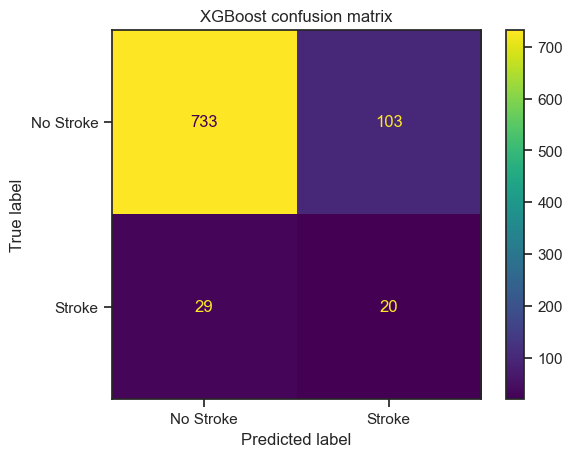

In [156]:
plot_cm(XGB_tuned, X_test, y_test)
plt.title("XGBoost confusion matrix")

Observation:

- After hyperparameter tuning, we can see that the XGBoost model is not bad at predicting the majority class, and it does not have too many false negatives which is a good sign.

- This improvement came at the expense of precision, however with the available data I believe this is the best this model can achieve. 

- In a real life scenario this model could be helpful at flagging potential stroke patients to help the decision making of medical professionals, but the final decision should not be down to the model's prediction.

Let's check the classification report for the best model:

In [157]:
report = classification_report(y_test, XGB_tuned.predict(X_test), output_dict=True)

report = pd.DataFrame(report).T

report

,precision,recall,f1-score,support
0,0.961942,0.876794,0.917397,836.000000
1,0.162602,0.408163,0.232558,49.000000
accuracy,0.850847,0.850847,0.850847,0.850847
macro avg,0.562272,0.642479,0.574977,885.000000
weighted avg,0.917685,0.850847,0.879479,885.000000


Observation:

- The classification report paints a different picture as it shows us the weighted avarages of the scores, which are calculated with class imbalance in mind. The XGBoost model performs well enough for both classes.

#### Random Forest Classifier

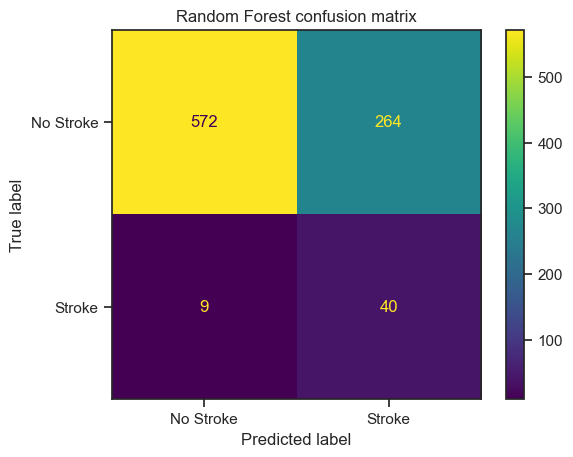

In [ ]:
plot_cm(RF_tuned, X_test, y_test)
_ = plt.title("Random Forest confusion matrix")

In [182]:
report = classification_report(y_test, RF_tuned.predict(X_test), output_dict=True)

report = pd.DataFrame(report).T

report

,precision,recall,f1-score,support
0,0.984509,0.684211,0.807339,836.000000
1,0.131579,0.816327,0.226629,49.000000
accuracy,0.691525,0.691525,0.691525,0.691525
macro avg,0.558044,0.750269,0.516984,885.000000
weighted avg,0.937285,0.691525,0.775187,885.000000


Observation:

- From both the confusion matrix and the classification report we can see that the Random Forest model performs well for the stroke class in terms of recall. 
- The precision is quite low but with the XGB classifier did not perform much better either.
- Overall this model performs better, however it is not as accurate.

Perhaps an ensemble of the two models would perform better.

### 3. Baseline evaluation

In [163]:
from sklearn.dummy import DummyClassifier

dummy = DummyClassifier(strategy="uniform", random_state=42)
dummy.fit(X_train, y_train)
dummy_score = dummy.score(X_test, y_test)
print(f"Dummy Classifier Accuracy: {dummy_score:.4f}")

Dummy Classifier Accuracy: 0.4932


Observation:

- The accuracy of both models is above the baseline, when using a uniform strategy, which generates predictions uniformly at random (so each class has a 50% chance of being predicted).

### 4. Model Ensembling

In [ ]:
from sklearn.ensemble import VotingClassifier

ensemble = VotingClassifier(
    estimators=[("RF", RF_tuned), ("XGB", XGB_tuned)],
    voting="soft",
    n_jobs=-1,
    weights=[5, 1],
)
ensemble.fit(X_train, y_train)

VotingClassifier(estimators=[('RF',
                              Pipeline(steps=[('preprocessor',
                                               ColumnTransformer(remainder='passthrough',
                                                                 transformers=[('for_binary_encoding',
                                                                                OrdinalEncoder(),
                                                                                ['gender',
                                                                                 'ever_married',
                                                                                 'Residence_type']),
                                                                               ('for_onehot_encoding',
                                                                                OneHotEncoder(sparse_output=False),
                                                                                ['work_type',
                                                                                 'smoking_status']),
                                                                               ('bmi',
                                                                                KNNImputer(),
                                                                                ['bmi'])])),
                                              ('eng',
                                               AutoFeatClassi...
                                                             interaction_constraints=None,
                                                             learning_rate=0.12021272701031692,
                                                             max_bin=None,
                                                             max_cat_threshold=None,
                                                             max_cat_to_onehot=None,
                                                             max_delta_step=None,
                                                             max_depth=6,
                                                             max_leaves=None,
                                                             min_child_weight=5.287571291648354,
                                                             missing=nan,
                                                             monotone_constraints=None,
                                                             multi_strategy=None,
                                                             n_estimators=775,
                                                             n_jobs=-1,
                                                             num_parallel_tree=None, ...))]))],
                 n_jobs=-1, voting='soft', weights=[5, 1])

In [205]:
hold_out_eval(ensemble, X_test, y_test)

,Performance
accuracy,0.774011
fbeta,0.409639
precision,0.155251
recall,0.693878
roc_auc,0.736293


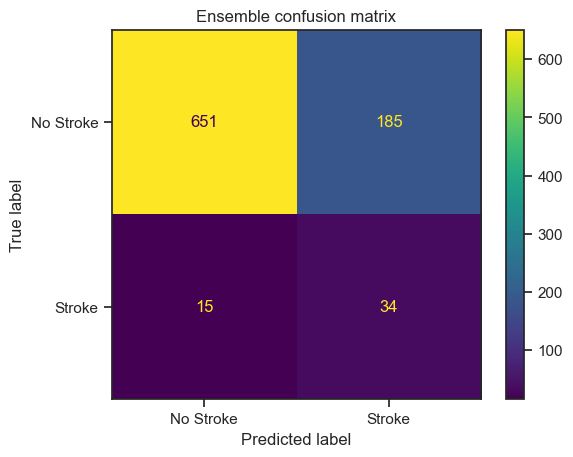

In [206]:
preds = ensemble.predict(X_test)
cm = confusion_matrix(y_test, preds)
ConfusionMatrixDisplay(cm, display_labels=["No Stroke", "Stroke"]).plot()
_ = plt.title("Ensemble confusion matrix")

In [193]:
report = classification_report(y_test, preds, output_dict=True)

report = pd.DataFrame(report).T

report

,precision,recall,f1-score,support
0,0.982275,0.795455,0.879048,836.00000
1,0.177885,0.755102,0.287938,49.00000
accuracy,0.793220,0.793220,0.793220,0.79322
macro avg,0.580080,0.775278,0.583493,885.00000
weighted avg,0.937738,0.793220,0.846320,885.00000


Observation:

- The ensemble model performs much better than the individual models for both classes.
- It is more precise than the Random Forest model and has a much higher recall than the XGBoost model.
- The accuracy is almost exactly the "golden" middle of the two models.

For deployment, I will be using the ensemble model.

# Model Interpretation & Serializing

In this section I will use SHAP to explain the predictions of the Random Forest model.

### 1. SHAP for Random forest.

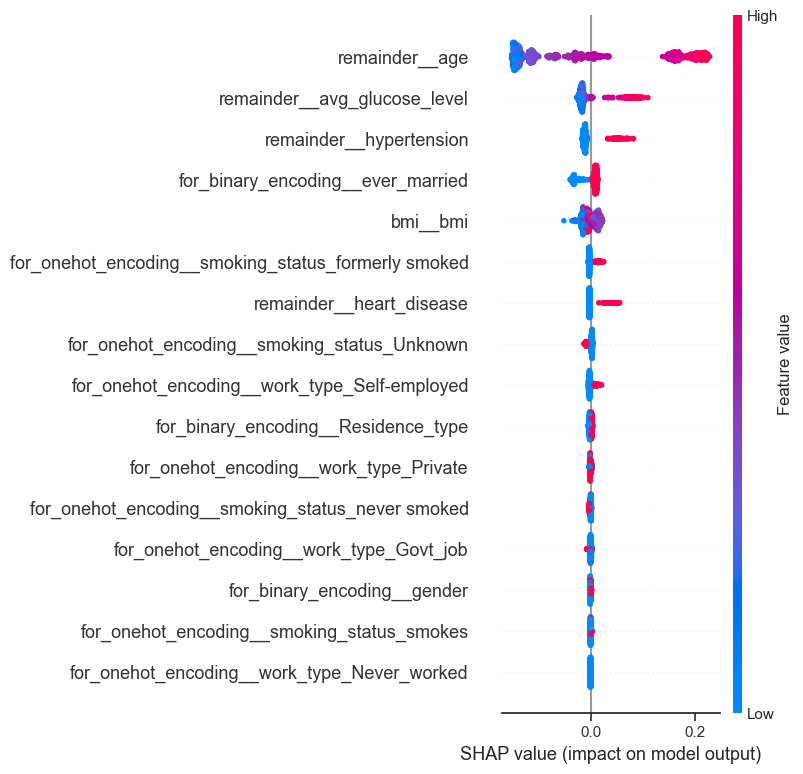

In [ ]:
X_test_transformed = RF_tuned[:-1].transform(X_test)

explainer = shap.TreeExplainer(RF_tuned.steps[-1][1], X_test_transformed)

shap_values = explainer.shap_values(X_test_transformed)

# shap_values[:,:,1].shape

shap.summary_plot(
    shap_values[:, :, 1],
    X_test_transformed,
)

Observation:

- The model has learnt that age is a major factor in determining the possibility of stroke.
- Glucose level has high predictive power too, although it is not very clear because the points jumble together.

Let's investigate the glucose level colum importance using a dependence plot:

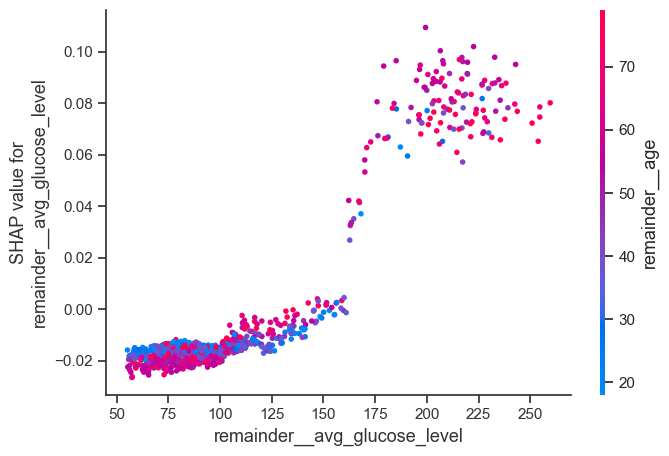

In [ ]:
shap.dependence_plot(
    "remainder__avg_glucose_level", shap_values[:, :, 1], X_test_transformed
)

Observation:

- The model has associated the glucose level with age.


Let's investigate the Residence type:

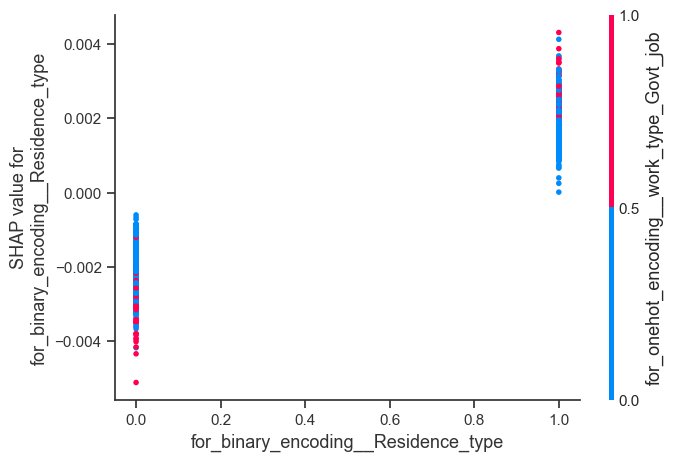

In [208]:
shap.dependence_plot(
    "for_binary_encoding__Residence_type", shap_values[:, :, 1], X_test_transformed
)

In [209]:
RF_tuned.named_steps["preprocessor"].transformers_[0][1].categories_[2]

array(['Rural', 'Urban'], dtype=object)

Observation:

- The model has learnt that individuals from Rural areas are less likely to have a stroke regardless of the work type.
- Government emplyees in Rural areas are even less likely to have a stroke, while those in the Urban areas have the highest SHAP values.

Next, I will be looking at age:

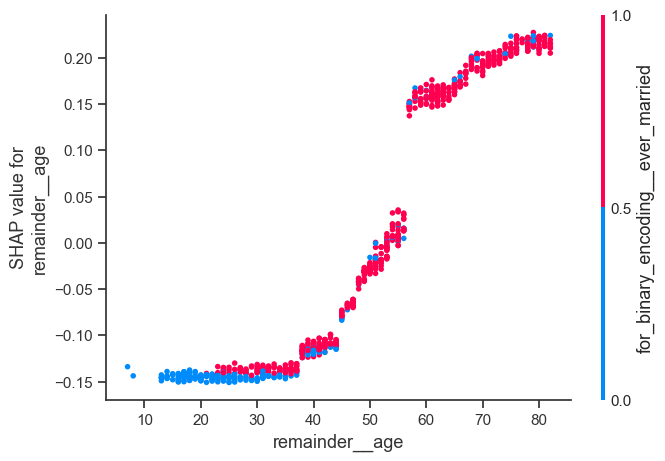

In [211]:
shap.dependence_plot("remainder__age", shap_values[:, :, 1], X_test_transformed)

Observation:

- The model seems to associate age with marital status.
- It seems that most married people belong to higher age groups in the dataset and they are thus more likely to have a stroke.
- Within the range of 22-45 years old, the model seems to have learnt that married people are more likely to have a stroke, than single individuals.

Finally, let's have a look at the self-employed predictor:

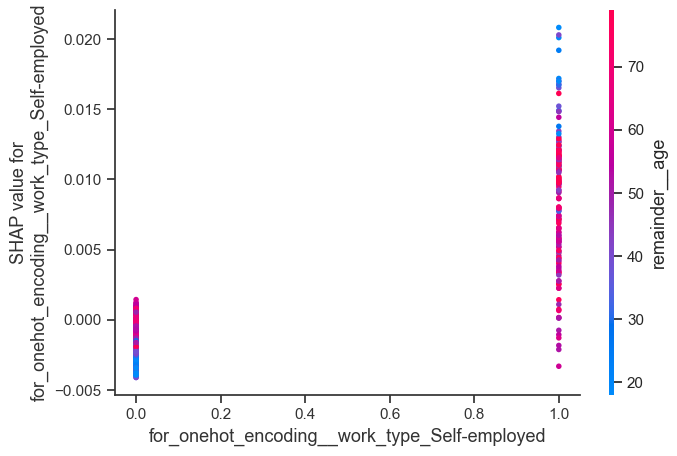

In [ ]:
shap.dependence_plot(
    "for_onehot_encoding__work_type_Self-employed",
    shap_values[:, :, 1],
    X_test_transformed,
)

Observation:

- The model has learnt that self-employed individuals are more likely to have a stroke when they are younger.

- In my opinion there definately is a confounding factor here. Perhaps the nature of the work differs with age? Perhaps it is linked to socio-economic status, which holds especially true if the data is collected from the US: older people have worked for longer and have more economic capital and thus can afford better helthcare and better insurance plans; while younger people cannot. On the other hand, those who are emplyed somewhere else usually have their health insurance paid by the employer.

### 2. SHAP for XGBoost

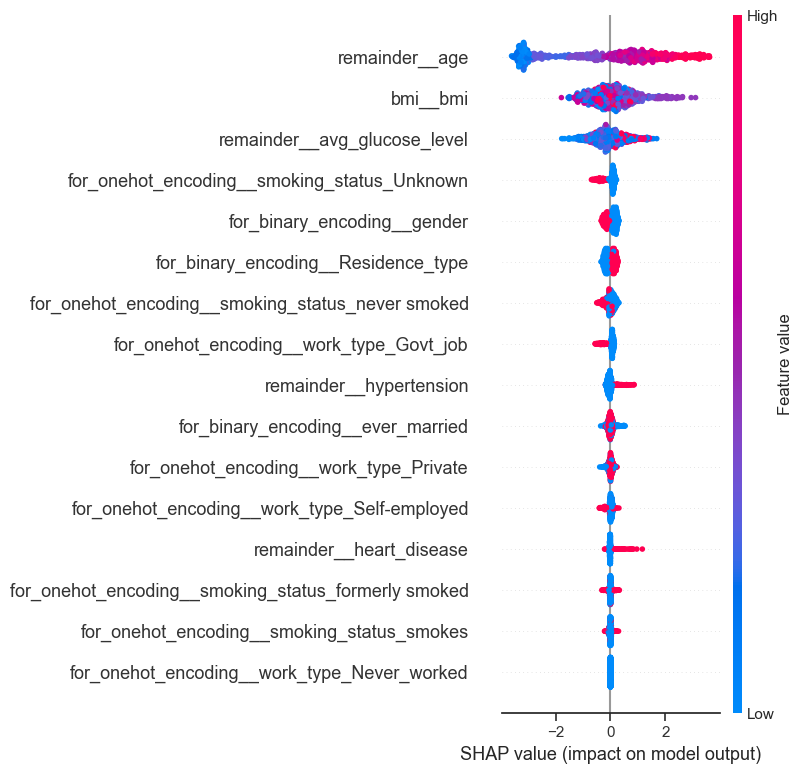

In [216]:
X_test_transformed = XGB_tuned[:-1].transform(X_test)

explainer = shap.TreeExplainer(XGB_tuned.steps[-1][1], X_test_transformed)

shap_values = explainer.shap_values(X_test_transformed)

shap.summary_plot(shap_values, X_test_transformed)

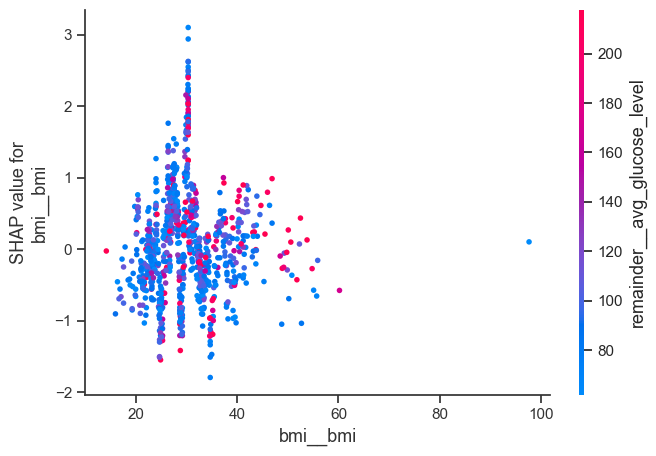

In [ ]:
shap.dependence_plot("bmi__bmi", shap_values, X_test_transformed)

### 3. Serializing

For deployment, I will need to serialize the ensemble model pipeline, create a fastAPI app and deploy it.

In [218]:
pickle.dump(ensemble, open("./app/stroke_model.pkl", "wb"))